In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import torch.optim as optim
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from scipy.stats import norm
from torchvision import datasets, transforms, utils

# Data

In [2]:
train_set_raw = datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)
test_set_raw = datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)
train_set = list(filter(lambda i: i[1] == 3 or i[1]==8 , train_set_raw))
test_set = list(filter(lambda i: i[1] == 3 or i[1]==8 , test_set_raw))


In [3]:
for i in range(len(train_set)): 
    if train_set[i][1]==3:
        lst=list(train_set[i])
        lst.append(0)
        lst.pop(1)
        train_set[i] = tuple(lst)

    elif train_set[i][1]==8:
        lst=list(train_set[i])
        lst.append(1)
        lst.pop(1)
        train_set[i] = tuple(lst)
    
    else :
        pass
        

In [4]:
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

# HyperParameter

In [5]:
EPOCHS = 200

# Selector

In [6]:
class Selector(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 2000
        self.actor = nn.Sequential(
            nn.Linear(784, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, 784),
        )

    def forward(self, x):
        x = x.view(-1,784)
        selection_probability = self.actor(x)
        return selection_probability


In [7]:
selector = Selector()

# Feature Selector

In [8]:
class FeatureSelector(nn.Module):
    def __init__(self, input_dim=784):
        super(FeatureSelector, self).__init__()
        self.mu = 0.01*torch.randn(input_dim, )
        self.noise = torch.randn(self.mu.size()) 
        self.sigma = 0.5  
    
    def forward(self, prev_x):
        self.mu = selector(prev_x)
        z = self.mu + self.sigma * self.noise.normal_()
        stochastic_gate = self.hard_sigmoid(z)
        new_x = prev_x * stochastic_gate
        return new_x
    
    def hard_sigmoid(self, x):
        return torch.clamp(x, 0.0, 1.0)

    def regularizer(self):
        ''' Gaussian CDF. '''
        return 0.5 * (1 + torch.erf(self.mu / math.sqrt(2))) 

    def get_gates(self):
        # 실제 gate 값 출력 
        # feature selection 여부 확인
        return self.mu.detach().cpu().numpy(), np.minimum(1.0, np.maximum(0.0, self.mu.detach().cpu().numpy())) 

In [9]:
feature_selector = FeatureSelector()

# Model

In [10]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 2000
        self.critic = nn.Sequential(
            nn.Linear(784, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, self.h_dim),
            nn.ReLU(),
            nn.Linear(self.h_dim, 2),
            nn.Softmax()
        )
        self.feature_selector = feature_selector
        self.regularizer = feature_selector.regularizer
        self.get_gates = feature_selector.get_gates
        
    def forward(self,x):
        x = x.view(-1,784)
        x = feature_selector(x)
        x = self.critic(x)
        return x

In [11]:
critic = Critic()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(critic.parameters(), lr = 1e-4)

In [12]:
def train(model, train_loader, optimizer, criterion):
    critic.train()
    train_loss = 0 
   
    for data, target in train_loader:
        input_x, target_x = data, target

        optimizer.zero_grad()
        output = model(input_x)
        regularizer = torch.mean(model.regularizer())
        loss = criterion(output,target_x) + 0.2 * regularizer 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

In [13]:
result_list = []
for epoch in range(0, EPOCHS + 1):
  train_loss=train(critic, train_loader,optimizer,criterion)
  #val_loss = evaluate(model, test_loader,criterion)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    #'Val Loss': val_loss,
    #'Val Accuracy': val_accuracy
    }
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)


/Users/dongjoon/opt/anaconda3/envs/Tobigs/lib/python3.9/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[EPOCH: 0], 	Train Loss: 0.5229
[EPOCH: 1], 	Train Loss: 0.4865
[EPOCH: 2], 	Train Loss: 0.4858


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

<AxesSubplot: >

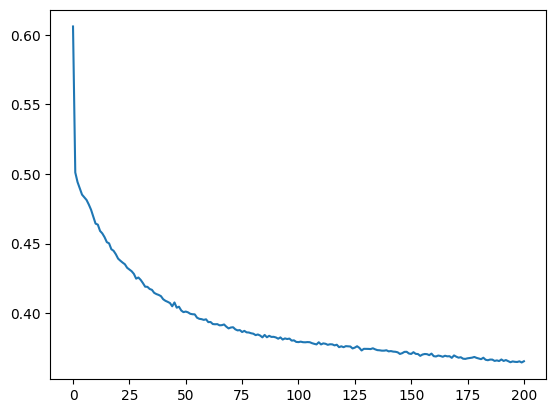

In [ ]:
result_df['Train Loss'].plot()

In [ ]:
raw, prob = model.get_gates()
#print('raw : ', raw)
print(" prob : ", prob)

 prob :  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

(-0.5, 27.5, 27.5, -0.5)

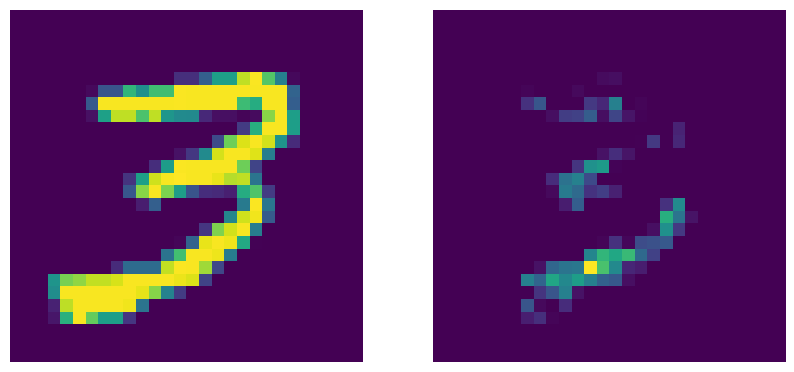

In [ ]:
test=train_set[100]
lst = list(test)
test = lst[0][0]
test_prob=prob.reshape(28,28)
final=test*test_prob

fig =  plt.figure(figsize=(10,20))
rows = 1 
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(test)
ax1.axis('off')

ax2= fig.add_subplot(rows,cols,2)
ax2.imshow(final)
ax2.axis('off')
